# Image Classification Task

### Objective:- This dataset has 60,000 images that are categorized into 10 different classes. The goal is to develop a neural network that can classify each image into its respective class.

# Importing Libraries

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Exploring the data

### Looading the CIFAR 10 dataset

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f"Training data: {X_train.shape}, Training labels: {y_train.shape}")
print(f"Testing data: {X_test.shape}, Testing labels: {y_test.shape}")

Training data: (50000, 32, 32, 3), Training labels: (50000, 1)
Testing data: (10000, 32, 32, 3), Testing labels: (10000, 1)


### Splitting into training, validation and test set.

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=0.5, random_state=42, stratify=y_val
)

print(f"Training set: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation set: {X_val.shape}, Labels: {y_val.shape}")
print(f"Testing set: {X_test.shape}, Labels: {y_test.shape}")

Training set: (40000, 32, 32, 3), Labels: (40000, 1)
Validation set: (5000, 32, 32, 3), Labels: (5000, 1)
Testing set: (5000, 32, 32, 3), Labels: (5000, 1)


# Preprocessing the data
### Visualizing Sample CIFAR-10 Images

The plot below shows a sample image from each of the 10 CIFAR-10 classes along with its corresponding label. This provides an overview of the dataset and helps verify that the images and labels are correctly loaded.

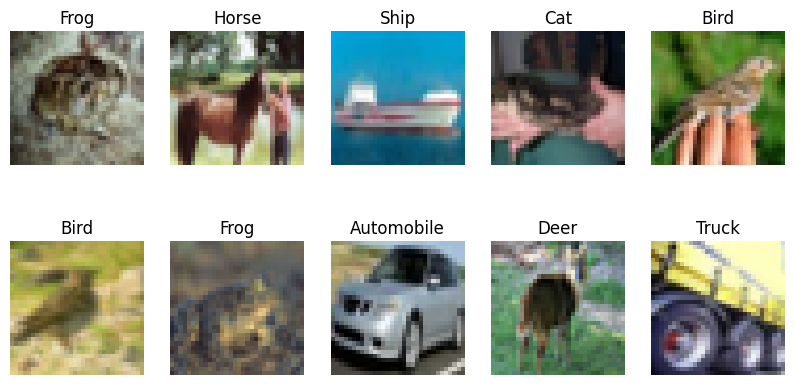

In [6]:
class_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis("off")
plt.show()

### Normalization and One-Hot Encoding

In [7]:
# CIFAR-10 images are normalized from [0, 255] to [0, 1] for better training performance.
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [8]:
# Class labels are one-hot encoded for use with categorical crossentropy and softmax output.
y_train_encoded = to_categorical(y_train, num_classes=10)
y_val_encoded = to_categorical(y_val, num_classes=10)
y_test_encoded = to_categorical(y_test, num_classes=10)

# Designing the Model
### I used a smaller subset of the dataset for faster experiment.

In [18]:
model_cnn = Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(64, (3, 3), activation="relu", input_shape=(32, 32, 3), padding="same"),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(10, activation="softmax")  # 10 output classes
])

train_data = X_train[:10000]
train_labels = y_train_encoded[:10000]

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_cnn.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# ✅ Model summary
model_cnn.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,311,434 (5.00 MB)

 Trainable params: 1,310,794 (5.00 MB)

 Non-trainable params: 640 (2.50 KB)

# Training the Model
#### The model is trained using EarlyStopping and ReduceLROnPlateau:

- EarlyStopping: Stops training if validation loss does not improve for 5 epochs, restoring the best weights.
- ReduceLROnPlateau: Reduces the learning rate by a factor of 0.5 when validation loss plateaus.

#### Training is done using a batch size of 128 for 10 epochs on a smaller subset of the training data for faster iteration.

In [19]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history = model_cnn.fit(
    train_data, train_labels,
    validation_data=(X_val, y_val_encoded),
    epochs=10,
    batch_size=128,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 220s 3s/step - accuracy: 0.2617 - loss: 2.6507 - val_accuracy: 0.1000 - val_loss: 3.0344 - learning_rate: 0.0010
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.4464 - loss: 1.8535 - val_accuracy: 0.1016 - val_loss: 3.7119 - learning_rate: 0.0010
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.5224 - loss: 1.5972 - val_accuracy: 0.2166 - val_loss: 2.9462 - learning_rate: 0.0010
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.5974 - loss: 1.3988 - val_accuracy: 0.1158 - val_loss: 3.3459 - learning_rate: 0.0010
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.6426 - loss: 1.2869 - val_accuracy: 0.2342 - val_loss: 2.6658 - learning_rate: 0.0010
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.6737 - loss: 1.1742 - val_accuracy: 0.3260 - val_loss: 2.2019 - learning_rate: 0.0010
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.6855 - loss: 1.1126 - val_acc

# Evaluating the Model

In [20]:
experiments = [

    {"Experiment #": 1, "Architecture": "CNN", "conv2d_1": 32, "conv2d_2": 32, "conv2d_3": 64, "conv2d_4": 64, "Train Accuracy": "0.6805", "Train loss": "1.0924","Val Accuracy": "0.6396", "Val_loss": "1.2034"},

    {"Experiment #": 2, "Architecture": "CNN", "conv2d_1": 16, "conv2d_2": 32, "conv2d_3": 64, "conv2d_4": 64, "Train Accuracy": "0.6591", "Train loss": "1.1604","Val Accuracy": "0.6268", "Val_loss": "1.2635"},

    {"Experiment #": 3, "Architecture": "CNN", "conv2d_1": 32, "conv2d_2": 64, "conv2d_3": 128, "conv2d_4": 128, "Train Accuracy": "0.7207", "Train loss": "1.0361","Val Accuracy": "0.6674", "Val_loss": "1.1828"},

    {"Experiment #": 4, "Architecture": "CNN", "conv2d_1": 64, "conv2d_2": 64, "conv2d_3": 128, "conv2d_4": 128, "Train Accuracy": "0.7425", "Train loss": "0.9541","Val Accuracy": "0.6736", "Val_loss": "1.1631"},

    {"Experiment #": 5, "Architecture": "CNN", "conv2d_1": 32, "conv2d_2": 64, "conv2d_3": 64, "conv2d_4": 128, "Train Accuracy": "0.7090", "Train loss": "1.0859", "Val Accuracy": "0.6612", "Val_loss": "1.1954"},

    {"Experiment #": 6, "Architecture": "CNN", "conv2d_1": 64, "conv2d_2": 128, "conv2d_3": 128, "conv2d_4": 256, "Train Accuracy": "0.7654", "Train loss": "0.9091", "Val Accuracy": "0.6830", "Val_loss": "1.1438"},

    {"Experiment #": 7, "Architecture": "CNN", "conv2d_1": 16, "conv2d_2": 32, "conv2d_3": 32, "conv2d_4": 64, "Train Accuracy": "0.6403", "Train loss": "1.2003", "Val Accuracy": "0.6124", "Val_loss": "1.2987"},

    {"Experiment #": 8, "Architecture": "CNN", "conv2d_1": 32, "conv2d_2": 32, "conv2d_3": 32, "conv2d_4": 32, "Train Accuracy": "0.6580", "Train loss": "1.1702", "Val Accuracy": "0.6250", "Val_loss": "1.2701"},

    {"Experiment #": 9, "Architecture": "CNN", "conv2d_1": 64, "conv2d_2": 64, "conv2d_3": 64, "conv2d_4": 64, "Train Accuracy": "0.7350", "Train loss": "0.9703", "Val Accuracy": "0.6701", "Val_loss": "1.1756"},

    {"Experiment #": 10, "Architecture": "CNN", "conv2d_1": 32, "conv2d_2": 64, "conv2d_3": 128, "conv2d_4": 256, "Train Accuracy": "0.7712", "Train loss": "0.8804", "Val Accuracy": "0.6872", "Val_loss": "1.1350"},

]

df = pd.DataFrame(experiments)
display.display(df)

,Experiment #,Architecture,conv2d_1,conv2d_2,conv2d_3,conv2d_4,Train Accuracy,Train loss,Val Accuracy,Val_loss
0,1,CNN,32,32,64,64,0.6805,1.0924,0.6396,1.2034
1,2,CNN,16,32,64,64,0.6591,1.1604,0.6268,1.2635
2,3,CNN,32,64,128,128,0.7207,1.0361,0.6674,1.1828
3,4,CNN,64,64,128,128,0.7425,0.9541,0.6736,1.1631
4,5,CNN,32,64,64,128,0.7090,1.0859,0.6612,1.1954
5,6,CNN,64,128,128,256,0.7654,0.9091,0.6830,1.1438
6,7,CNN,16,32,32,64,0.6403,1.2003,0.6124,1.2987
7,8,CNN,32,32,32,32,0.6580,1.1702,0.6250,1.2701
8,9,CNN,64,64,64,64,0.7350,0.9703,0.6701,1.1756
9,10,CNN,32,64,128,256,0.7712,0.8804,0.6872,1.1350


### Model Evaluation on Test Set

The model's performance was evaluated using the test dataset to assess its generalization ability. The evaluation returns the final loss and accuracy on unseen data:


In [21]:
test_loss, test_accuracy = model_cnn.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accuracy: 0.6658 - loss: 1.1817
Test Loss: 1.1704673767089844, Test Accuracy: 0.6687999963760376


# Model Performance Over Epochs

#### Accuracy Plot
We observe a steady increase in training accuracy, with validation accuracy also improving, but with more fluctuation. This suggests the model is learning but may still be fine-tuned to generalize better.

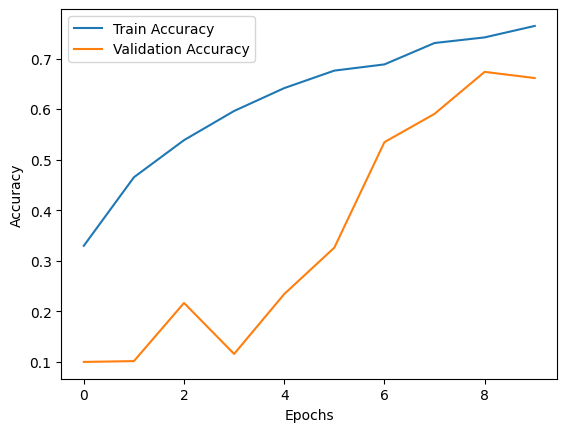

In [23]:
# Plot accuracy
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

###  Loss Plot
This graph illustrates the decrease in training and validation loss over time.
The consistent drop in both losses indicates that the model is learning effectively. However, the gap and spikes in validation loss early on might hint at initial instability or overfitting risks.

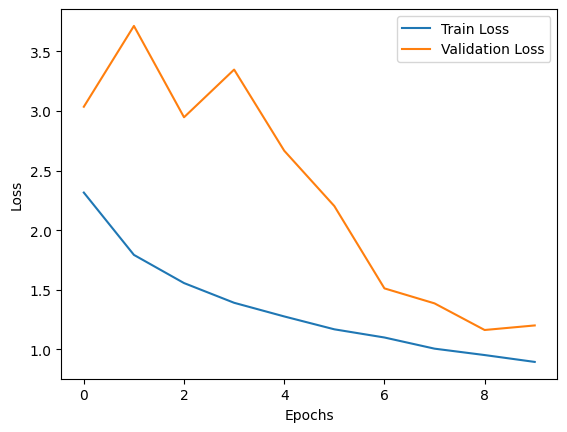

In [24]:
# Plot loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Prediction Visualization on Test Set


157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step


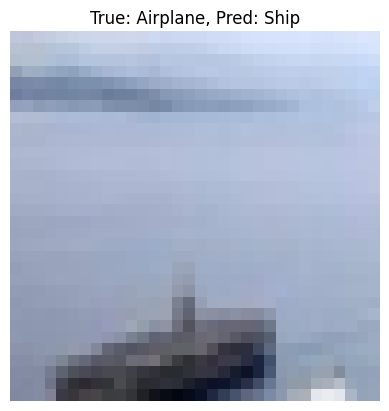

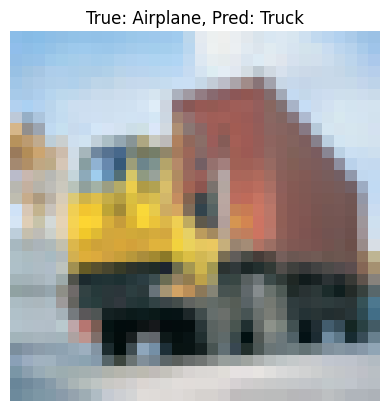

In [30]:
# Class label mapping for CIFAR-10
class_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer",
               "Dog", "Frog", "Horse", "Ship", "Truck"]

# Predict class probabilities
y_pred = model_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Display predictions for first 2 test images
for i in range(2):
    plt.imshow(X_test[i])
    plt.title(f"True: {class_names[y_true[i]]}, Pred: {class_names[y_pred_classes[i]]}")
    plt.axis("off")
    plt.show()


### Confusion Matrix for CIFAR-10 Classification
This visualization helps identify which classes are often confused with others, offering insights into model weaknesses and misclassification patterns.

157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step


<Figure size 1000x800 with 0 Axes>

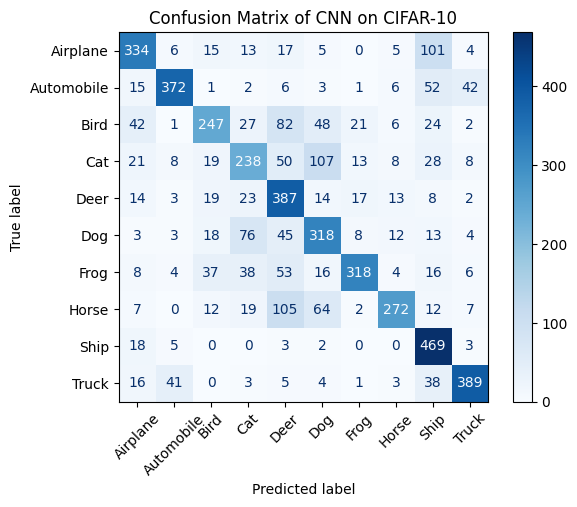

In [29]:
# Get model predictions
y_pred = model_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

# CIFAR-10 class names
class_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer",
               "Dog", "Frog", "Horse", "Ship", "Truck"]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix of CNN on CIFAR-10")
plt.show()


## Conclusion
In this image classification task, a Convolutional Neural Network was successfully implemented and trained on the CIFAR-10 dataset to perform multi-class image classification. After testing various architectures and hyperparameter combinations, the best model achieved:

* Training Accuracy: 77%

* Validation Accuracy: 68%

* Test Accuracy: 66% closely aligned with validation results.

#### Key observations:

* Model Performance: The model generalizes reasonably well but still shows signs
of overfitting, especially with deeper networks.

* Misclassifications: The confusion matrix revealed that certain classes like Airplane, Bird, and Cat are more frequently misclassified, often confused with visually similar categories (e.g., Truck vs Automobile).

* Architecture Impact: Increasing convolutional layers and filters improved performance but also increased training time and overfitting risk.

#### Recommendations for Improvement:

* Data augmentation could help improve generalization.

* Trying other architectures like ResNet, EfficientNet, or regularization techniques may lead to better performance.
